## Gradient Boosting

Gradient boost algorithm is a generalized boosting algorithm that can be used for both classification and regression tasks, which uses decision trees as base learners.

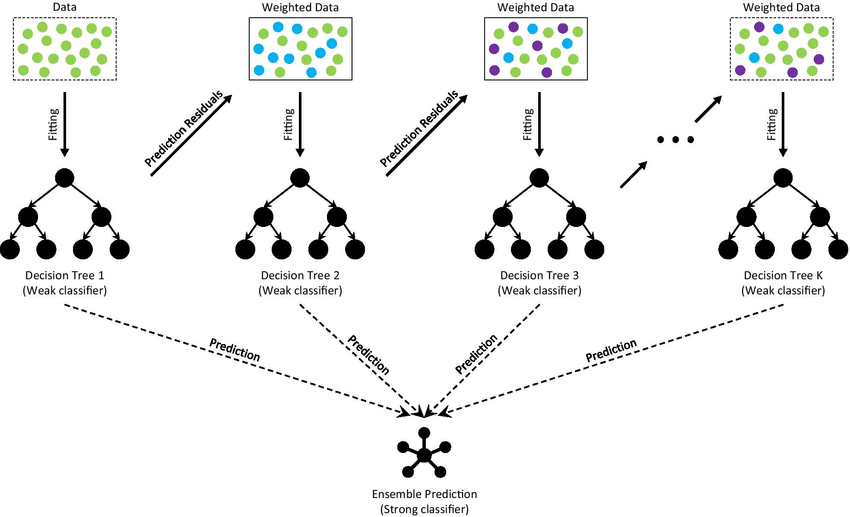

<b>Note that AdaBoost is a special case of gradient boosting algorithm that uses stumps (decision tree with max depth 1 and 2 leaf nodes).</b>

<b>Assumptions of Gradient Boosting:</b>
1. Independence of observations
2. Strictly additive model for depth of 1. The larger the number of depths, the less strictly additive the model is.

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of Gradient Boost:</b>
1. Able to handle missing data
2. Flexible model that allows optimizing different loss functions
3. Captures non-linear relationships

<b>Disadvantages of Gradient Boost:</b>
1. Prone to overfitting, such that outliers may be overemphasized unless regularization is used
2. Computationally expensive
3. Large space of hyperparameter tuning required
4. Difficult to interpret final model

<b>Time complexity of model training: O(n*log(n)*f*m)</b>

<b>Time complexity of model prediction: O(k*m)</b>

<b>Space complexity of model prediction: O(p * m + b * m) </b>

n - Number of training samples

f - Number of features

k - Depth of decision tree

p - Number of nodes in decision tree

m - Number of decision trees

b - Shrinkage factor (Learning rate)

Extra Notes:
- In scikit-learn, gradient boosting algorithms have histogram based algorithms that are faster for larger datasets (>10000 samples) with built-in support for handling missing values (using indicator of missing value as split factor) and non-ordered categorical features.

- The reason why gradient boosting algorithms is generally slower for larger datasets due to sorting samples at every node for every feature when building decision trees with time complexity of O(f * n log(n)). Histogram based gradient boosting algorithms have time complexity of O(f*n), which is much smaller than using standard gradient boosting algorithms (<b>n split points to consider for gradient-boosting and max_bin split points to consider for histogram-based, where max_bins < n</b>)

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## GradientBoosting for regression

<b>Important hyperparameters for GradientBoostingRegressor</b>:
- learning_rate: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and num_estimators values - Learning rate set as 1 indicating no shrinkage)
- num_estimators: Maximum number of estimators before boosting algorithm terminates
- subsample: Fraction of samples used to fit individual base learners
- max_features: Number of features to consider when looking for splits

- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes

For regression tasks, gradient boost algorithm makes final prediction from test data by using the following formula:

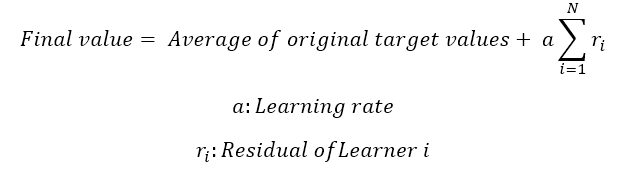

<b>For larger datasets with samples > 10000, HistGradientBoostingRegressor is a suitable alternative that is much faster than standard GradientBoostingRegressor.</b>

<b>Important hyperparameters for HistGradientBoostingRegressor</b>:
1. learning_rate: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and num_estimators values - Learning rate set as 1 indicating no shrinkage)
2. num_estimators: Maximum number of estimators before boosting algorithm terminates
3. max_depth: Maximum depth of decision tree
4. min_samples_leaf: Minimum number of samples required for leaf nodes
5. max_leaf_nodes: Maximum number of leaves for every tree
6. l2_regularization: L2 regularization parameter

## Practical steps of Gradient Boost algorithm (Regression)

The following steps are involved in the Gradient Boost algorithm for regression:

1. Set initial prediction value as average of all target values for all rows in the dataset.


2. Compute pseudo residuals as follows:
- Pseudo residual = Actual value - Average value from 1st step

3. Construct a decision tree with pseudo residuals as outputs of decision tree. Pseudo residuals that belong to the same leaf node will be averaged accordingly.


4. New prediction values are made using the following formula for all rows in the dataset:
- <b>New prediction value = Average value from 1st step + learning rate * residual predicted from 3rd step</b>

5. Compute new residual values as follows:
- New residual = Actual value - New prediction value from step 4

6. <b>Repeat steps 3 to 5 until number of estimators is reached</b> as specified in the model or the model fails to improve the fit by specified tolerance threshold.

Note that the most common loss function used in regression task for gradient boost algorithm is <b>half of MSE</b> as follows:

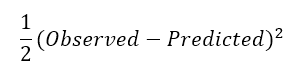

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = HistGradientBoostingRegressor(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__learning_rate'] = Real(0.01,1,'log-uniform')
search_space['regression__max_leaf_nodes'] = Integer(10,50)
search_space['regression__max_depth'] = Integer(2,10)
search_space['regression__min_samples_leaf'] = Integer(20,100)
search_space['regression__l2_regularization'] = Real(0,1)
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.8557352502628301
Best hyperparameters for fold 1: OrderedDict([('regression__l2_regularization', 0.16294650993963525), ('regression__learning_rate', 0.013854813998537312), ('regression__max_depth', 2), ('regression__max_leaf_nodes', 14), ('regression__min_samples_leaf', 33)])
Test RMSE for fold 1: 0.8140036521704964
Validation RMSE for fold 2: 0.7449019695856685
Best hyperparameters for fold 2: OrderedDict([('regression__l2_regularization', 0.19898491818397507), ('regression__learning_rate', 0.04073456262534908), ('regression__max_depth', 2), ('regression__max_leaf_nodes', 40), ('regression__min_samples_leaf', 51)])
Test RMSE for fold 2: 0.6712974400711121
Validation RMSE for fold 3: 0.7207879028984653
Best hyperparameters for fold 3: OrderedDict([('regression__l2_regularization', 0.4981971112817999), ('regression__learning_rate', 0.9926963378108037), ('regression__max_depth', 5), ('regression__max_leaf_nodes', 23), ('regression__min_samples_leaf', 74)])
T

## GradientBoosting for Classification

<b>Important hyperparameters for GradientBoostingClassifier</b>:
- learning_rate: Weight applied to each classifier at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and num_estimators values - Learning rate set as 1 indicating no shrinkage)
- num_estimators: Maximum number of estimators before boosting algorithm terminates
- subsample: Fraction of samples used to fit individual base learners
- max_features: Number of features to consider when looking for splits

- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes

<b>Methods to handle imbalanced dataset for classification</b>:
1. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)
2. Assign sample_weight to fit method

For classification tasks, gradient boost algorithm makes final prediction from test data by using the following formula:

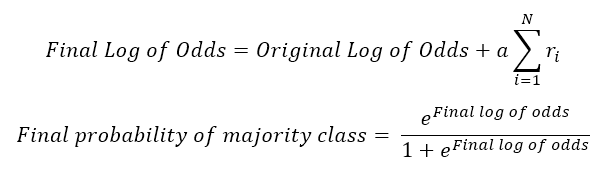

<b>For larger datasets with samples > 10000 or large number of target classes, HistGradientBoostingClassifier is a suitable alternative that is much faster than standard GradientBoostingClassifier.</b>

<b>Important hyperparameters for HistGradientBoostingClassifier</b>:
1. learning_rate: Weight applied to each classifier at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and num_estimators values - Learning rate set as 1 indicating no shrinkage)
2. max_iter: Maximum number of estimators before boosting algorithm terminates
3. max_depth: Maximum depth of decision tree
4. min_samples_leaf: Minimum number of samples required for leaf nodes
5. max_leaf_nodes: Maximum number of leaves for every tree
6. l2_regularization: L2 regularization parameter

## Practical steps of Gradient Boost algorithm (Binary Classification)

The following steps are involved in the Gradient Boost algorithm for binary classification:

1. Compute log of odds between two classes as follows:

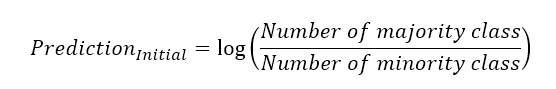

2. Set initial constant probability of majority class using the following formula for every row in the dataset:

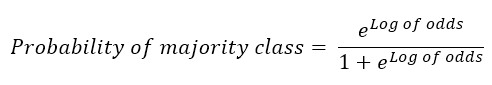

3. Compute pseudo residuals as follows:
- Pseudo residual = Actual binary outcome (0 or 1) - Previous probability of majority class

4. Construct a decision tree with pseudo residuals as outputs of decision tree. 

5. Outputs from pseudo residuals need to be transformed using the following formula:

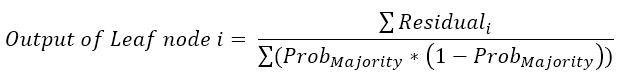

6. New log of odds values are made using the following formula for all rows in the dataset:
- <b>New log of odds = Previous log of odds + learning rate * output from 5th step</b>

7. New probability of majority class for every row is set using the following formula:

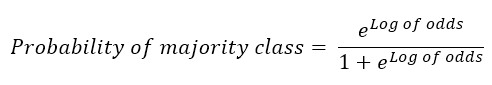

8. <b>Repeat steps 3 to 7 until number of estimators is reached</b> as specified in the model or the model fails to improve the fit by specified tolerance threshold.

Note that the most common loss function used in classification task for gradient boost algorithm is <b>negative log-likelihood</b> as follows:

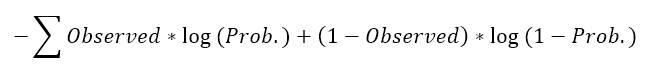

In [5]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [6]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [7]:
clf = DecisionTreeClassifier(random_state=120)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas[:-1]

In [8]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - GradientBoostingClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.954970708206092
Best hyperparameters for fold 1: OrderedDict([('classification__ccp_alpha', 0.010955056179775272), ('classification__learning_rate', 0.02211513485427815), ('classification__subsample', 0.6055048234415299)])
Test F1 score for fold 1: 1.0



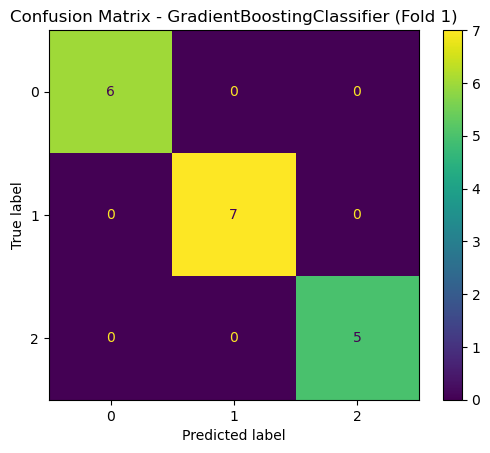


Validation F1 score for fold 2: 0.9370530759901957
Best hyperparameters for fold 2: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__learning_rate', 0.2305422220394615), ('classification__subsample', 0.5017716107379598)])
Test F1 score for fold 2: 1.0



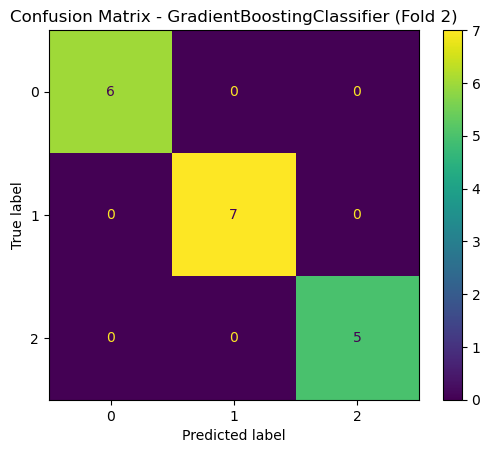


Validation F1 score for fold 3: 0.9564846042467525
Best hyperparameters for fold 3: OrderedDict([('classification__ccp_alpha', 0.021110973919962684), ('classification__learning_rate', 0.17151767597957757), ('classification__subsample', 0.5500148084514321)])
Test F1 score for fold 3: 0.9487179487179486



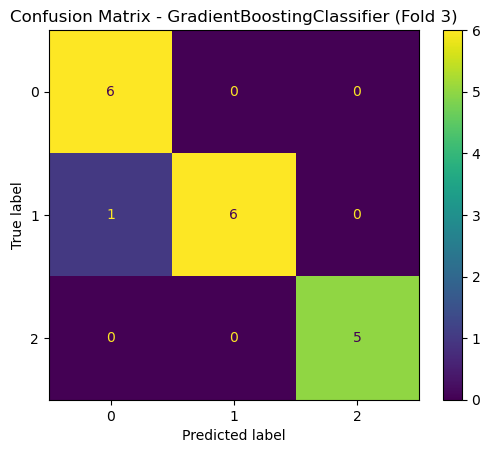


Validation F1 score for fold 4: 0.9271704946746899
Best hyperparameters for fold 4: OrderedDict([('classification__ccp_alpha', 0.02171015044753381), ('classification__learning_rate', 0.1504966368658864), ('classification__subsample', 0.5600507413644901)])
Test F1 score for fold 4: 1.0



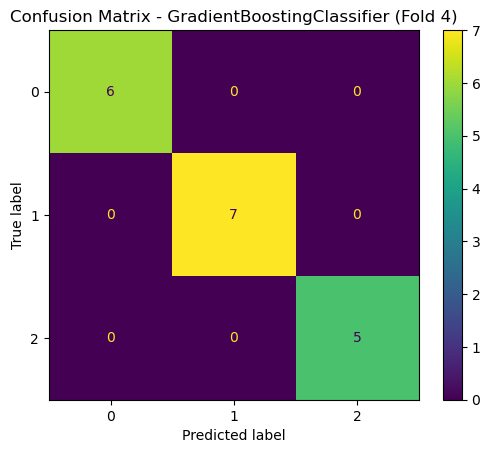


Validation F1 score for fold 5: 0.9435639291923813
Best hyperparameters for fold 5: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__learning_rate', 0.025406580577327604), ('classification__subsample', 0.6084966954216069)])
Test F1 score for fold 5: 1.0



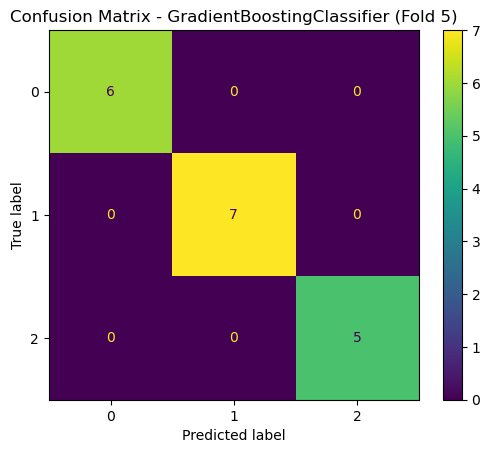


Validation F1 score for fold 6: 0.936598121713301
Best hyperparameters for fold 6: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__learning_rate', 0.037676929952615734), ('classification__subsample', 0.6603945818345885)])
Test F1 score for fold 6: 1.0



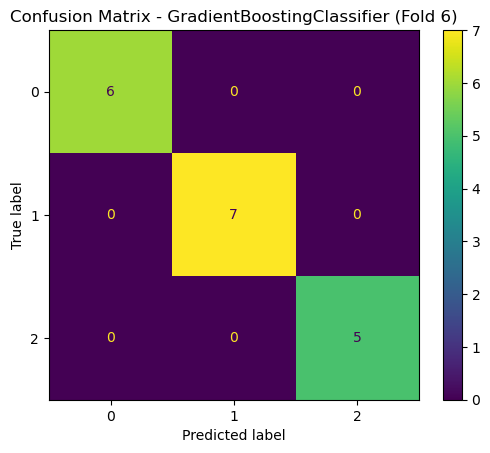


Validation F1 score for fold 7: 0.9329092199169823
Best hyperparameters for fold 7: OrderedDict([('classification__ccp_alpha', 0.009363295880149813), ('classification__learning_rate', 0.0991825490274768), ('classification__subsample', 0.5123849682862631)])
Test F1 score for fold 7: 0.9474747474747475



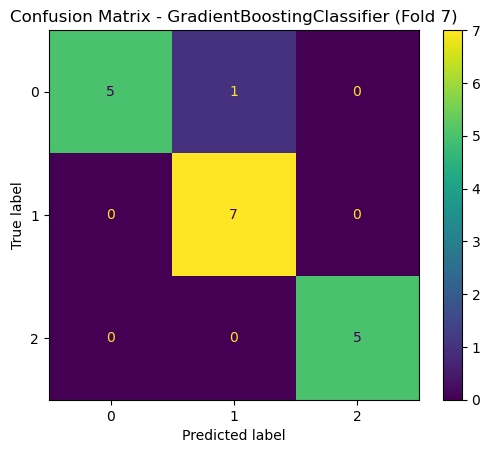


Validation F1 score for fold 8: 0.956763985838424
Best hyperparameters for fold 8: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__learning_rate', 0.12632081650083582), ('classification__subsample', 0.6072469089205256)])
Test F1 score for fold 8: 0.9474747474747475



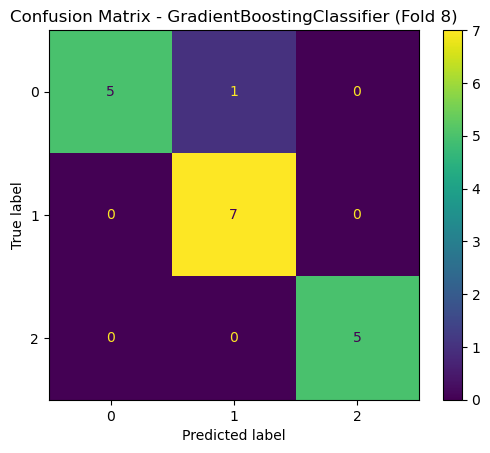


Validation F1 score for fold 9: 0.9515870290550599
Best hyperparameters for fold 9: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__learning_rate', 0.20630082340248834), ('classification__subsample', 0.5343252638799852)])
Test F1 score for fold 9: 0.9373219373219372



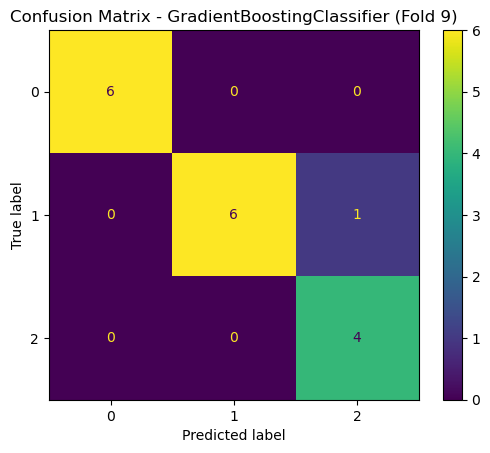


Validation F1 score for fold 10: 0.9404591114736043
Best hyperparameters for fold 10: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__learning_rate', 0.0523485718576458), ('classification__subsample', 0.5995850478138869)])
Test F1 score for fold 10: 0.8850408850408851



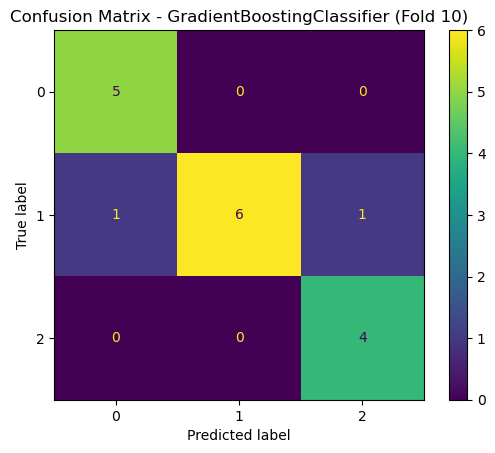


----------------------
Average validation F1 score: 0.9437560280307483
Average test F1 score: 0.9666030266030268


In [9]:
clf = GradientBoostingClassifier(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__ccp_alpha'] = Categorical(ccp_alphas)
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__subsample'] = Real(0.5,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

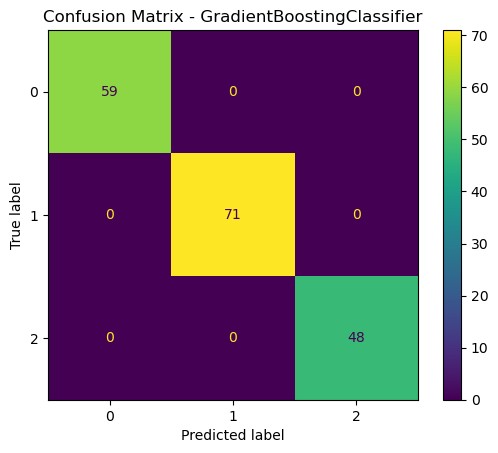

In [10]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - GradientBoostingClassifier")
plt.grid(False)
plt.show()